## Create ML-ready dataset for a Regional Grain Size Model

* Dan Buscombe 
* Will Speiser

3/24/22 - May 2022

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import folium
import io
from PIL import Image
import os, time
# from selenium import webdriver
# import geocoder
from tqdm import tqdm
import geopandas as gpd
# import pygeos

#### data processing choices

This number has to factor in very large errors in some g-s position data

In [2]:
# join_dist=.0005
# join_dist=.001
# join_dist=.0015
# join_dist=.003
join_dist=.004

In [3]:
# choice = 'beach'
choice = 'transects'

In [4]:
merge = 'right'
# merge = 'left'

#### read gs data 

In [85]:
# dataset = 'Data_Post2012_VerifiedOnshore'
dataset = 'Data_VerifiedOnshore'

In [86]:
dataset2 = 'sed_data_wrangle_final'

In [87]:
path='../../../orig_data/US_SAtlantic/CGRASP/'

In [88]:
cgrasp_dat = pd.read_csv(path+'/'+dataset+'.csv')
sand = cgrasp_dat[cgrasp_dat['d50']<2]


In [89]:
np.unique(cgrasp_dat['dataset'])

array(['BOEM', 'C_Alexander', 'SusanBell_UniversitySouthernFlorida',
       'UMASS', 'USGS East Coast Sediment Texture Database', 'bicms',
       'mcfall_via_weigl', 'rossi', 'sandsnap'], dtype=object)

In [90]:
cgrasp_dat = cgrasp_dat[cgrasp_dat['dataset']!='mcfall_via_weigl']

In [91]:
np.unique(cgrasp_dat['dataset'])

array(['BOEM', 'C_Alexander', 'SusanBell_UniversitySouthernFlorida',
       'UMASS', 'USGS East Coast Sediment Texture Database', 'bicms',
       'rossi', 'sandsnap'], dtype=object)

In [92]:
# len(sand)

In [96]:
cgrasp_dat2 = pd.read_csv(path+'/'+dataset2+'.csv')
sand2 = cgrasp_dat2[cgrasp_dat2['d50']<2]

In [97]:
sand2

,ID,Sample_ID,Sample_Type_Code,Project,dataset,Date,Location_Type,latitude,longitude,Contact,...,d16,d25,d30,d50,d65,d75,d84,d90,d95,Notes
0,NaN,bgb_ll_0,NaN,NaN,Fenster et al (2016),NaN,NaN,34.644333,-77.093597,NaN,...,NaN,NaN,NaN,0.221333,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,bgb_ll_1,NaN,NaN,Fenster et al (2016),NaN,NaN,34.656164,-77.051974,NaN,...,NaN,NaN,NaN,0.236769,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,bgb_ll_2,NaN,NaN,Fenster et al (2016),NaN,NaN,34.666089,-77.008725,NaN,...,NaN,NaN,NaN,0.260023,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,bgb_ll_3,NaN,NaN,Fenster et al (2016),NaN,NaN,34.673963,-76.965366,NaN,...,NaN,NaN,NaN,0.273288,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,bgb_ll_4,NaN,NaN,Fenster et al (2016),NaN,NaN,34.680743,-76.921918,NaN,...,NaN,NaN,NaN,0.283492,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,NaN,Boyton Inlet- R152,NaN,NaN,Briggs (2022),2/26/2017,NaN,26.544250,-80.043676,NaN,...,NaN,NaN,NaN,0.380000,NaN,NaN,NaN,NaN,NaN,Mid logger 45cm depth
194,NaN,Boyton (Ocean Ridge) - R156,NaN,NaN,Briggs (2022),2/13/2018,NaN,26.531520,-80.046917,NaN,...,NaN,NaN,NaN,0.440000,NaN,NaN,NaN,NaN,NaN,OR Mid 7-17-17
195,NaN,Delray South - Atlantic Dunes,NaN,NaN,Briggs (2022),2/14/2017,NaN,26.441889,-80.061608,NaN,...,NaN,NaN,NaN,0.290000,NaN,NaN,NaN,NaN,NaN,Mid logger 45 cm 9/22/16
196,NaN,Juno Beach,NaN,NaN,Briggs (2022),10/27/2020,NaN,26.885410,-80.054640,NaN,...,NaN,NaN,NaN,0.390000,NaN,NaN,NaN,NaN,NaN,R34 MS


In [98]:
np.unique(sand2['dataset'])

array(['Briggs (2022)', 'Fenster et al (2016)'], dtype=object)

In [99]:
# len(sand2)

In [100]:
merged_sand = pd.concat([sand, sand2])

In [101]:
merged_sand = merged_sand[merged_sand['d50']>.063]

In [102]:
merged_sand['d50'].max()

1.92916893

In [103]:
merged_sand['d50'].min()

0.066067513

In [104]:
# gdf_sand = gpd.GeoDataFrame(
#     sand, geometry=gpd.points_from_xy(sand.longitude, sand.latitude))

gdf_merged_sand = gpd.GeoDataFrame(
    merged_sand, geometry=gpd.points_from_xy(merged_sand.longitude, merged_sand.latitude))

In [105]:
# len(gdf_sand)
len(gdf_merged_sand)

4233

In [106]:
gdf_merged_sand['dataset'][gdf_merged_sand['dataset']=='sandsnap']='McFall, 2022'

C:\Users\dbuscombe\AppData\Local\Temp\1\ipykernel_21652\1144441917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_merged_sand['dataset'][gdf_merged_sand['dataset']=='sandsnap']='McFall, 2022'


In [107]:
gdf_merged_sand = gdf_merged_sand[gdf_merged_sand['dataset']!='UMASS']

In [108]:
np.unique(gdf_merged_sand['dataset'])

array(['BOEM', 'Briggs (2022)', 'C_Alexander', 'Fenster et al (2016)',
       'McFall, 2022', 'SusanBell_UniversitySouthernFlorida',
       'USGS East Coast Sediment Texture Database', 'bicms', 'rossi'],
      dtype=object)

In [109]:
len(gdf_merged_sand)

3341

In [110]:
# 'SusanBell_UniversitySouthernFlorida'

#### read slope data 

In [111]:
# slopes_t = pd.DataFrame(gpd.read_file('../../../orig_data/US_SAtlantic/beach_slopes/US_East_coast_slopes_by_transect.geojson'))
# slopes_b = pd.DataFrame(gpd.read_file('../../../orig_data/US_SAtlantic/beach_slopes/US_East_coast_slopes_by_beach.geojson'))

slopes_t = pd.DataFrame(gpd.read_file('../../../orig_data/US_SAtlantic/beach_slopes/US_East_coast_slopes_by_transect_v3.geojson'))
slopes_b = pd.DataFrame(gpd.read_file('../../../orig_data/US_SAtlantic/beach_slopes/US_East_coast_slopes_by_beach_v3.geojson'))


In [112]:
len(slopes_t)

34067

In [113]:
slopes_t['points'] = slopes_t.apply(lambda x: [y for y in x['geometry'].coords], axis=1)
latlon = np.vstack([np.mean(s,axis=0) for s in slopes_t.points.values])

slopes_t.insert(2, "longitude", latlon[:,0], True)
slopes_t.insert(3, "latitude", latlon[:,1], True)

In [114]:
slopes_b['points'] = slopes_b.apply(lambda x: [y for y in x['geometry'].coords], axis=1)
latlon = np.vstack([np.mean(s,axis=0) for s in slopes_b.points.values])

slopes_b.insert(2, "longitude", latlon[:,0], True)
slopes_b.insert(3, "latitude", latlon[:,1], True)

In [115]:
slopes_b.keys()

Index(['id', 'beach_slope_weighted_average', 'longitude', 'latitude',
       'width_ci_average', 'quality_flag', 'beach_slope_average',
       'beach_slope_median', 'sl_points_average', 'mstr', 'prc_mstr_obs',
       'min_tide_obs', 'max_tide_obs', 'easting', 'northing', 'geometry',
       'points'],
      dtype='object')

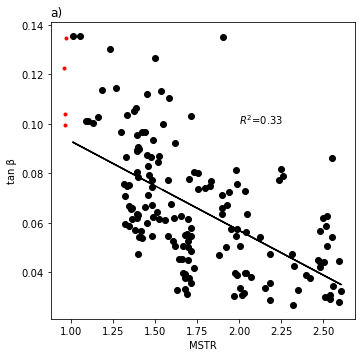

In [116]:
X = np.vstack((slopes_b['mstr'],slopes_b['beach_slope_average']))

X = X[:,~np.isnan(X).any(axis=0)]

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.plot(X[0,:],X[1,:], 'r.')

ind = np.where(X[0,:]>=1)[0]
X = X[:,ind]

X.shape
plt.plot(X[0,:],X[1,:], 'ko')

plt.ylabel(r'tan β')
plt.xlabel(r'MSTR')
plt.title(r"a)", loc='left')
r2 = np.min(np.corrcoef(X[0,:],X[1,:]))**2
plt.text(2,.1,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(X[0,:],X[1,:],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(X[0,:], poly1d_fn(X[0,:]), '-k')

# plt.savefig('data_plots/Partial_correl_a.jpg', dpi=300, bbox_inches='tight')

#### plot grain size and slope data on map

In [117]:
# map = folium.Map(
#                 location=[np.mean(sand['latitude']), np.mean(sand['longitude'])], 
#                 zoom_start=4, 
#                 control_scale=True,
#                 tiles='stamentoner',#tiles="Stamen Terrain", 
# )

In [118]:
# for counter, (lat,lon) in enumerate(zip(sand['latitude'],sand['longitude'])):
#     folium.CircleMarker(location=[lat, lon],
#                                 radius = 3,
#                                 fill=True, # Set fill to True
#                                 color = 'red',
#                                 opacity=0.1,
#                                 fill_opacity=0.7).add_to(map)

In [119]:
# for counter, (lat,lon) in enumerate(zip(slopes_t['latitude'],slopes_t['longitude'])):
#     folium.CircleMarker(location=[lat, lon],
#                                 radius = 3,
#                                 fill=True, # Set fill to True
#                                 color = 'blue',
#                                 opacity=0.1,
#                                 fill_opacity=0.7).add_to(map)

In [120]:
# for counter, (lat,lon) in enumerate(zip(slopes_b['latitude'],slopes_b['longitude'])):
#     folium.CircleMarker(location=[lat, lon],
#                                 radius = 3,
#                                 fill=True, # Set fill to True
#                                 color = 'magenta',
#                                 opacity=0.1,
#                                 fill_opacity=0.7).add_to(map)

In [121]:
# map

In [122]:
choice

'transects'

In [123]:
merge

'right'

In [124]:
if choice=='transects':
    gdf_slopes_b = gpd.GeoDataFrame(
    slopes_b, geometry=gpd.points_from_xy(slopes_b.longitude, slopes_b.latitude))

    gdf_slopes_t = gpd.GeoDataFrame(
    slopes_t, geometry=gpd.points_from_xy(slopes_t.longitude, slopes_t.latitude))    
    
    gdf_slopes = gpd.sjoin_nearest(gdf_slopes_b, gdf_slopes_t, how=merge, distance_col='distance')
    
else:
    gdf_slopes = gpd.GeoDataFrame(
    slopes_b, geometry=gpd.points_from_xy(slopes_b.longitude, slopes_b.latitude))  
    
len(gdf_slopes)  

34067

In [125]:
gdf_slopes.keys()

Index(['index_left', 'id_left', 'beach_slope_weighted_average',
       'longitude_left', 'latitude_left', 'width_ci_average',
       'quality_flag_left', 'beach_slope_average', 'beach_slope_median',
       'sl_points_average', 'mstr', 'prc_mstr_obs', 'min_tide_obs',
       'max_tide_obs', 'easting', 'northing', 'points_left', 'id_right',
       'site_id', 'longitude_right', 'latitude_right', 'beach_slope',
       'lower_conf_bound', 'upper_conf_bound', 'width_ci',
       'quality_flag_right', 'sl_points', 'trend', 'geometry', 'points_right',
       'distance'],
      dtype='object')

In [126]:
gdf_slopes = gdf_slopes[['beach_slope_weighted_average',
       'longitude_left', 'latitude_left', 'width_ci_average',
       'quality_flag_left', 'beach_slope_average', 'beach_slope_median',
       'sl_points_average', 'mstr', 'prc_mstr_obs', 'min_tide_obs',
       'max_tide_obs','site_id', 'longitude_right', 'latitude_right', 'beach_slope',
       'lower_conf_bound', 'upper_conf_bound', 'width_ci','geometry',
       'quality_flag_right', 'sl_points', 'trend',
       'distance']].copy()

# gdf_slopes = gdf_slopes[['beach_slope_weighted_average', 'longitude', 'latitude',
#        'width_ci_average', 'quality_flag', 'beach_slope_average','distance'
#        'beach_slope_median', 'sl_points_average', 'mstr', 'prc_mstr_obs',
#        'min_tide_obs', 'max_tide_obs', 'easting', 'northing', 'geometry',
#        'points']].copy()

gdf_slopes = gpd.GeoDataFrame(gdf_slopes)

type(gdf_slopes)

geopandas.geodataframe.GeoDataFrame

In [127]:
# gs_w_slope_data=gpd.sjoin_nearest(gdf_sand, gdf_slopes, how=merge)#, distance_col='distance')
gs_w_slope_data=gpd.sjoin_nearest(gdf_merged_sand, gdf_slopes, how=merge)

len(gs_w_slope_data)

61849

In [128]:
gdf_slopes.keys()


Index(['beach_slope_weighted_average', 'longitude_left', 'latitude_left',
       'width_ci_average', 'quality_flag_left', 'beach_slope_average',
       'beach_slope_median', 'sl_points_average', 'mstr', 'prc_mstr_obs',
       'min_tide_obs', 'max_tide_obs', 'site_id', 'longitude_right',
       'latitude_right', 'beach_slope', 'lower_conf_bound', 'upper_conf_bound',
       'width_ci', 'geometry', 'quality_flag_right', 'sl_points', 'trend',
       'distance'],
      dtype='object')

In [129]:
ind = np.where(gs_w_slope_data['distance']<join_dist)[0]
tmp = gs_w_slope_data.iloc[ind]
len(tmp)

3592

In [130]:
tmp = tmp[['latitude', 'longitude', 'd50', 'geometry', 'dataset',
       'longitude_left', 'latitude_left', 'quality_flag_right','quality_flag_left',
        'beach_slope_average','sl_points', 'trend', 'width_ci_average',
       'beach_slope_median', 'sl_points_average', 'mstr', 'prc_mstr_obs',
       'min_tide_obs', 'max_tide_obs', 'site_id', 'longitude_right',
       'latitude_right', 'beach_slope', 'lower_conf_bound', 'upper_conf_bound',
       'width_ci', 'distance']].copy() 

#''d25', 'd30','d65', 'd75',

In [131]:
len(tmp.dropna())

3584

In [132]:
tmp = tmp.dropna()

In [133]:
tmp.keys()

Index(['latitude', 'longitude', 'd50', 'geometry', 'dataset', 'longitude_left',
       'latitude_left', 'quality_flag_right', 'quality_flag_left',
       'beach_slope_average', 'sl_points', 'trend', 'width_ci_average',
       'beach_slope_median', 'sl_points_average', 'mstr', 'prc_mstr_obs',
       'min_tide_obs', 'max_tide_obs', 'site_id', 'longitude_right',
       'latitude_right', 'beach_slope', 'lower_conf_bound', 'upper_conf_bound',
       'width_ci', 'distance'],
      dtype='object')

In [134]:
np.unique(tmp['dataset'])

array(['Briggs (2022)', 'C_Alexander', 'Fenster et al (2016)',
       'McFall, 2022', 'USGS East Coast Sediment Texture Database',
       'rossi'], dtype=object)

In [135]:
## original
# array(['BOEM', 'Briggs (2022)', 'C_Alexander', 'Fenster et al (2016)',
#        'McFall, 2022', 'SusanBell_UniversitySouthernFlorida',
#        'USGS East Coast Sediment Texture Database', 'bicms', 'rossi'],
#       dtype=object)

In [136]:
tmp['d50'].max()

1.798733766

In [137]:
tmp['d50'].min()

0.090577125

In [138]:
# try:
#     map = folium.Map(
#                     location=[np.mean(tmp['latitude_right']), np.mean(tmp['longitude_right'])], 
#                     zoom_start=4, 
#                     control_scale=True,
#                     tiles='stamentoner',#tiles="Stamen Terrain", 
#     )
    
#     for counter, (lat,lon) in enumerate(zip(tmp['latitude_right'],tmp['longitude_right'])):
#         folium.CircleMarker(location=[lat, lon],
#                                     radius = 3,
#                                     fill=True, # Set fill to True
#                                     color = 'magenta',
#                                     opacity=0.1,
#                                     fill_opacity=0.7).add_to(map)

# except:
#     map = folium.Map(
#                     location=[np.mean(tmp['latitude_left']), np.mean(tmp['longitude_left'])], 
#                     zoom_start=4, 
#                     control_scale=True,
#                     tiles='stamentoner',#tiles="Stamen Terrain", 
#     )
    
#     for counter, (lat,lon) in enumerate(zip(tmp['latitude_left'],tmp['longitude_left'])):
#         folium.CircleMarker(location=[lat, lon],
#                                     radius = 3,
#                                     fill=True, # Set fill to True
#                                     color = 'magenta',
#                                     opacity=0.1,
#                                     fill_opacity=0.7).add_to(map)
    
# map

Text(0.25, 0.16, '$R^2$=0.00')

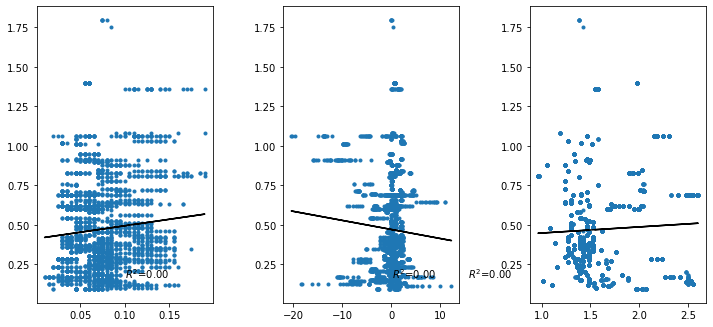

In [139]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.4)
plt.subplot(231)
plt.plot(tmp['beach_slope'],tmp['d50'],'.')

coef = np.polyfit(tmp['beach_slope'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['beach_slope'], poly1d_fn(tmp['beach_slope']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['beach_slope']))**2
plt.text(.1,.16,r'$R^2$='+str(r2)[:4])

plt.subplot(232)
plt.plot(tmp['trend'],tmp['d50'],'.')

coef = np.polyfit(tmp['trend'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['trend'], poly1d_fn(tmp['trend']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['trend']))**2
plt.text(.25,.16,r'$R^2$='+str(r2)[:4])

plt.subplot(233)
plt.plot(tmp['mstr'],tmp['d50'],'.')

coef = np.polyfit(tmp['mstr'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['mstr'], poly1d_fn(tmp['mstr']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['mstr']))**2
plt.text(.25,.16,r'$R^2$='+str(r2)[:4])

#### merge waves

In [140]:
dir_df=pd.read_csv('../../../orig_data/US_SAtlantic/WaveData/Dir.csv')
hsmax_df=pd.read_csv('../../../orig_data/US_SAtlantic/WaveData/HsMax.csv')
hsmean_df=pd.read_csv('../../../orig_data/US_SAtlantic/WaveData/HsMean.csv')
tp_df=pd.read_csv('../../../orig_data/US_SAtlantic/WaveData/Tp.csv')

In [141]:
dir_df = dir_df.rename(columns={"lat": "latitude", "lon": "longitude"})
hsmax_df = hsmax_df.rename(columns={"lat": "latitude", "lon": "longitude"})
hsmean_df = hsmean_df.rename(columns={"lat": "latitude", "lon": "longitude"})
tp_df = tp_df.rename(columns={"lat": "latitude", "lon": "longitude"})


In [142]:
#rename wave variable dataframe columns to yyyy-mm-dd format
i=0
for i in tqdm(range(0,len(dir_df.columns)-2)):
    focus_col=dir_df.columns[2+i]
    timestamps = pd.to_datetime(int(focus_col)-719529, unit='D').strftime("%Y-%m-%d")
    stamp=str(timestamps)
    dir_df=dir_df.rename(columns={focus_col:stamp})
    i=i+1
    
print('dir done')
#rename wave variable dataframe columns to yyyy-mm-dd format
i=0
for i in tqdm(range(0,len(hsmax_df.columns)-2)):
    focus_col=hsmax_df.columns[2+i]
    timestamps = pd.to_datetime(int(focus_col)-719529, unit='D').strftime("%Y-%m-%d")
    stamp=str(timestamps)
    hsmax_df=hsmax_df.rename(columns={focus_col:stamp})
    i=i+1
    
print('hsmax done')

i=0
for i in tqdm(range(0,len(hsmean_df.columns)-2)):
    focus_col=hsmean_df.columns[2+i]
    timestamps = pd.to_datetime(int(focus_col)-719529, unit='D').strftime("%Y-%m-%d")
    stamp=str(timestamps)
    hsmean_df=hsmean_df.rename(columns={focus_col:stamp})
    i=i+1
    
print('hsmean done')

i=0
for i in tqdm(range(0,len(tp_df.columns)-2)):
    focus_col=tp_df.columns[2+i]
    timestamps = pd.to_datetime(int(focus_col)-719529, unit='D').strftime("%Y-%m-%d")
    stamp=str(timestamps)
    tp_df=tp_df.rename(columns={focus_col:stamp})
    i=i+1
    
print('tp done')


100%|████████████████████████████████████████████████████████| 10713/10713 [05:23<00:00, 33.15it/s]


dir done


100%|████████████████████████████████████████████████████████| 10713/10713 [04:24<00:00, 40.43it/s]


hsmax done


100%|████████████████████████████████████████████████████████| 10713/10713 [03:57<00:00, 45.13it/s]


hsmean done


100%|████████████████████████████████████████████████████████| 10713/10713 [03:47<00:00, 47.01it/s]

tp done


In [143]:
df=tmp.copy()
df=pd.DataFrame(df)

# df

In [144]:
df= gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [145]:
# df.keys()

In [146]:
dir_gdf= gpd.GeoDataFrame(
    dir_df, geometry=gpd.points_from_xy(dir_df.longitude, dir_df.latitude))

# dirmerge=gpd.sjoin_nearest(df, dir_gdf, how='left', distance_col='distance')
dirmerge=gpd.sjoin_nearest(df, dir_gdf, how=merge)#, distance_col='distance')

filter_col = [col for col in dirmerge if col.startswith('20')]
dirmerge.insert(0, "dir", dirmerge[filter_col].mean(axis=1).values, True)

len(dirmerge)

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\geopandas\geodataframe.py:1378: FutureWarning: Passing 'suffixes' which cause duplicate columns {'latitude_left', 'longitude_left'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


13746

In [147]:

hsmean_gdf= gpd.GeoDataFrame(
    hsmean_df, geometry=gpd.points_from_xy(hsmean_df.longitude, hsmean_df.latitude))

hsmeanmerge=gpd.sjoin_nearest(df, hsmean_gdf, how=merge)#, distance_col='distance')

filter_col = [col for col in hsmeanmerge if col.startswith('20')]
hsmeanmerge.insert(0, "hs_mean", hsmeanmerge[filter_col].mean(axis=1).values, True)


hsmax_gdf= gpd.GeoDataFrame(
    hsmax_df, geometry=gpd.points_from_xy(hsmax_df.longitude, hsmax_df.latitude))

hsmaxmerge=gpd.sjoin_nearest(df, hsmax_gdf, how=merge)#, distance_col='distance')

filter_col = [col for col in hsmaxmerge if col.startswith('20')]
hsmaxmerge.insert(0, "hs_max", hsmaxmerge[filter_col].mean(axis=1).values, True)


tp_gdf= gpd.GeoDataFrame(
    tp_df, geometry=gpd.points_from_xy(tp_df.longitude, tp_df.latitude))

tpmerge=gpd.sjoin_nearest(df, tp_gdf, how=merge)#, distance_col='distance')

filter_col = [col for col in tpmerge if col.startswith('20')]
tpmerge.insert(0, "tp", tpmerge[filter_col].mean(axis=1).values, True)


C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\geopandas\geodataframe.py:1378: FutureWarning: Passing 'suffixes' which cause duplicate columns {'latitude_left', 'longitude_left'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\geopandas\geodataframe.py:1378: FutureWarning: Passing 'suffixes' which cause duplicate columns {'latitude_left', 'longitude_left'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\geopandas\geodataframe.py:1378: FutureWarning: Passing 'suffixes' which cause duplicate columns {'latitude_left', 'longitude_left'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


In [148]:
# tpmerge.keys()[:40]

In [149]:
out_df = tpmerge[['tp', 'latitude_left', 'longitude_left', 'quality_flag_left','quality_flag_right',
       'd50', 'width_ci_average',  'beach_slope_average', 'dataset',
       'beach_slope_median', 'sl_points_average', 'mstr', 'prc_mstr_obs',
       'min_tide_obs', 'max_tide_obs', 'site_id', 'beach_slope', 'lower_conf_bound', 'upper_conf_bound',
       'width_ci',  'sl_points', 'trend', 'distance',
       'latitude_right', 'longitude_right']].copy()

#'d25', 'd30','d65', 'd75', 

In [150]:
out_df.insert(0, "dir", dirmerge.iloc[:, [0]].values.squeeze(), True)
out_df.insert(0, "hs_mean", hsmeanmerge.iloc[:, [0]].values.squeeze(), True)
out_df.insert(0, "hs_max", hsmaxmerge.iloc[:, [0]].values.squeeze(), True)
out_df = out_df.dropna()

out_df = out_df.drop_duplicates()

In [151]:
len(out_df)

13313

In [152]:
np.unique(out_df['dataset'])

array(['Briggs (2022)', 'C_Alexander', 'Fenster et al (2016)',
       'McFall, 2022', 'USGS East Coast Sediment Texture Database',
       'rossi'], dtype=object)

In [153]:
# np.unique(out_df['dataset'])

In [154]:
# array(['Briggs (2022)', 'C_Alexander', 'Fenster et al (2016)',
#        'McFall, 2022', 'USGS East Coast Sediment Texture Database',
#        'rossi'], dtype=object)

In [155]:
# join_dist = 0.004

In [181]:
ind = np.where(out_df['distance']<join_dist)[0]
tmp = out_df.iloc[ind]
len(tmp)

13313

In [182]:
np.unique(tmp['dataset'])

array(['Briggs (2022)', 'C_Alexander', 'Fenster et al (2016)',
       'McFall, 2022', 'USGS East Coast Sediment Texture Database',
       'rossi'], dtype=object)

In [183]:
tmp = tmp.drop_duplicates()
len(tmp)

13313

In [184]:
np.unique(tmp['dataset'])

array(['Briggs (2022)', 'C_Alexander', 'Fenster et al (2016)',
       'McFall, 2022', 'USGS East Coast Sediment Texture Database',
       'rossi'], dtype=object)

In [185]:
tmp['d50'].max()

1.798733766

In [186]:
tmp['d50'].min()

0.090577125

Text(0.25, 0.16, '$R^2$=0.05')

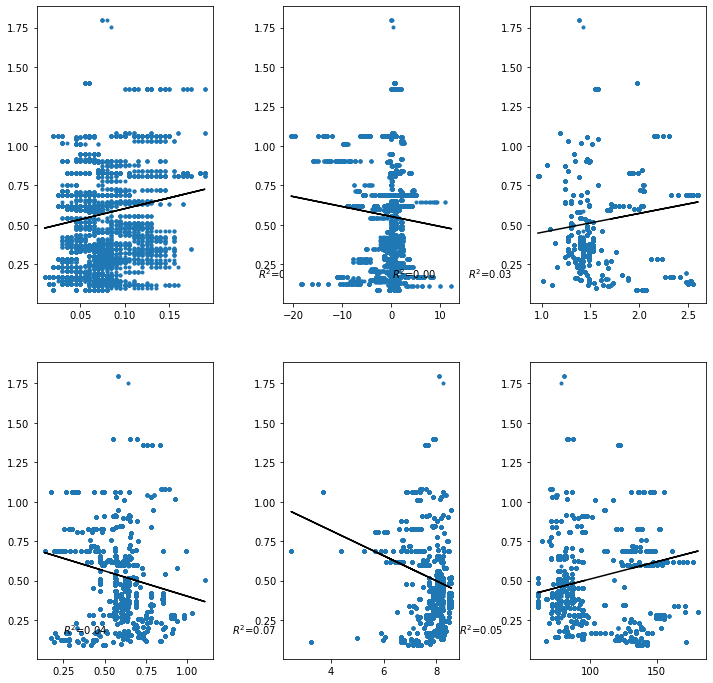

In [187]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.4)
plt.subplot(231)
plt.plot(tmp['beach_slope'],tmp['d50'],'.')

coef = np.polyfit(tmp['beach_slope'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['beach_slope'], poly1d_fn(tmp['beach_slope']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['beach_slope']))**2
plt.text(.25,.16,r'$R^2$='+str(r2)[:4])

plt.subplot(232)
plt.plot(tmp['trend'],tmp['d50'],'.')

coef = np.polyfit(tmp['trend'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['trend'], poly1d_fn(tmp['trend']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['trend']))**2
plt.text(.25,.16,r'$R^2$='+str(r2)[:4])

plt.subplot(233)
plt.plot(tmp['mstr'],tmp['d50'],'.')

coef = np.polyfit(tmp['mstr'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['mstr'], poly1d_fn(tmp['mstr']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['mstr']))**2
plt.text(.25,.16,r'$R^2$='+str(r2)[:4])


plt.subplot(234)
plt.plot(tmp['hs_mean'],tmp['d50'],'.')

coef = np.polyfit(tmp['hs_mean'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['hs_mean'], poly1d_fn(tmp['hs_mean']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['hs_mean']))**2
plt.text(.25,.16,r'$R^2$='+str(r2)[:4])

plt.subplot(235)
plt.plot(tmp['tp'],tmp['d50'],'.')

coef = np.polyfit(tmp['tp'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['tp'], poly1d_fn(tmp['tp']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['tp']))**2
plt.text(.25,.16,r'$R^2$='+str(r2)[:4])

plt.subplot(236)
plt.plot(tmp['dir'],tmp['d50'],'.')

coef = np.polyfit(tmp['dir'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['dir'], poly1d_fn(tmp['dir']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['dir']))**2
plt.text(.25,.16,r'$R^2$='+str(r2)[:4])

In [162]:
# ind = np.where(tmp['distance']<join_dist)[0]
# tmp = tmp.iloc[ind]
# len(tmp)

In [188]:
tmp['latitude']=np.mean(tmp['latitude_right'],axis=1)
tmp['longitude']=np.mean(tmp['longitude_right'],axis=1)
tmp=tmp.drop(columns=['latitude_right','longitude_right'])

In [189]:
tmp.keys()

Index(['hs_max', 'hs_mean', 'dir', 'tp', 'latitude_left', 'latitude_left',
       'longitude_left', 'longitude_left', 'quality_flag_left',
       'quality_flag_right', 'd50', 'width_ci_average', 'beach_slope_average',
       'dataset', 'beach_slope_median', 'sl_points_average', 'mstr',
       'prc_mstr_obs', 'min_tide_obs', 'max_tide_obs', 'site_id',
       'beach_slope', 'lower_conf_bound', 'upper_conf_bound', 'width_ci',
       'sl_points', 'trend', 'distance', 'latitude', 'longitude'],
      dtype='object')

In [190]:
np.unique(tmp['dataset'])

array(['Briggs (2022)', 'C_Alexander', 'Fenster et al (2016)',
       'McFall, 2022', 'USGS East Coast Sediment Texture Database',
       'rossi'], dtype=object)

In [191]:
len(tmp)

13313

In [192]:
briggs = tmp[tmp['dataset']=='Briggs (2022)']

In [193]:
Alexander = tmp[tmp['dataset']=='C_Alexander']

In [194]:
len(briggs)

32

In [195]:
len(Alexander)

617

### write to file

In [196]:
# dataset = '../model_data/ML_slope_wave_atlantic_2022-05-18_'+dataset+'_'+str(join_dist)+'_'+merge+'_'+choice+'.csv'
# dataset = '../model_data/ML_slope_wave_atlantic_2022-08-31_'+dataset+'_'+str(join_dist)+'_'+merge+'_'+choice+'.csv'
# dataset = '../model_data/ML_slope_wave_atlantic_2022-09-04_'+dataset+'_'+str(join_dist)+'_'+merge+'_'+choice+'.csv'
dataset_name = 'Data_VerifiedOnshore'

dataset = '../model_data/ML_slope_wave_atlantic_2022-09-20_'+dataset_name+'_'+str(join_dist)+'_'+merge+'_'+choice+'.csv'


In [197]:
dataset

'../model_data/ML_slope_wave_atlantic_2022-09-20_Data_VerifiedOnshore_0.004_right_transects.csv'

In [199]:
tmp.tail()

,hs_max,hs_mean,dir,tp,latitude_left,latitude_left,longitude_left,longitude_left,quality_flag_left,quality_flag_right,...,site_id,beach_slope,lower_conf_bound,upper_conf_bound,width_ci,sl_points,trend,distance,latitude,longitude
249,0.676577,0.531904,130.889076,7.502859,38.76664,38.757278,-75.08173,-75.08202,Low,Low,...,usa_DE_0004,0.125,0.1027,0.1659,0.0632,425.0,0.312723,0.002966,38.778965,-75.072844
249,0.676577,0.531904,130.889076,7.502859,38.76664,38.757278,-75.08173,-75.08202,Low,Low,...,usa_DE_0004,0.165,0.1203,0.2000,0.0797,428.0,0.298768,0.003082,38.779190,-75.072854
249,0.676577,0.531904,130.889076,7.502859,38.76664,38.757278,-75.08173,-75.08202,Low,Low,...,usa_DE_0004,0.150,0.1133,0.2000,0.0867,434.0,0.296927,0.003257,38.779416,-75.072865
249,0.676577,0.531904,130.889076,7.502859,38.76664,38.757278,-75.08173,-75.08202,Low,Low,...,usa_DE_0004,0.140,0.1101,0.1936,0.0835,434.0,0.220553,0.003481,38.779641,-75.072876
249,0.676577,0.531904,130.889076,7.502859,38.76664,38.757278,-75.08173,-75.08202,Low,Low,...,usa_DE_0004,0.165,0.1239,0.2000,0.0761,431.0,0.228431,0.003746,38.779867,-75.072888


In [200]:
tmp.to_csv(dataset)

In [201]:
# dataset

In [202]:
choice = 'transects'
merge = 'right'


In [223]:
tmp = pd.read_csv(dataset)
len(tmp)

13313

In [224]:
ind = np.where(tmp['quality_flag_right']!='Low')[0]
len(ind)
tmp = tmp.iloc[ind]
len(tmp)

ind = np.where(tmp['quality_flag_left']!='Low')[0]
len(ind)
tmp = tmp.iloc[ind]
len(tmp)

11274

In [225]:
np.unique(tmp['dataset'])

array(['C_Alexander', 'Fenster et al (2016)', 'McFall, 2022',
       'USGS East Coast Sediment Texture Database', 'rossi'], dtype=object)

In [226]:
tmp = tmp[tmp['dataset']!='USGS East Coast Sediment Texture Database']

In [227]:
df_strat_lat = tmp.copy()

num_cats=34
num_samples_per_category = 30

df_strat_lat['category'] = pd.cut(tmp['latitude'], num_cats)
df_strat_lat = df_strat_lat.groupby(['category']).apply(lambda x: x.sample(num_samples_per_category, replace = True)).reset_index(drop = True)

len(df_strat_lat)

1020

In [228]:
np.unique(df_strat_lat['dataset'])

array(['C_Alexander', 'Fenster et al (2016)', 'McFall, 2022', 'rossi'],
      dtype=object)

In [210]:
# array(['Briggs (2022)', 'C_Alexander', 'Fenster et al (2016)',
#        'McFall, 2022', 'USGS East Coast Sediment Texture Database',
#        'rossi'], dtype=object)

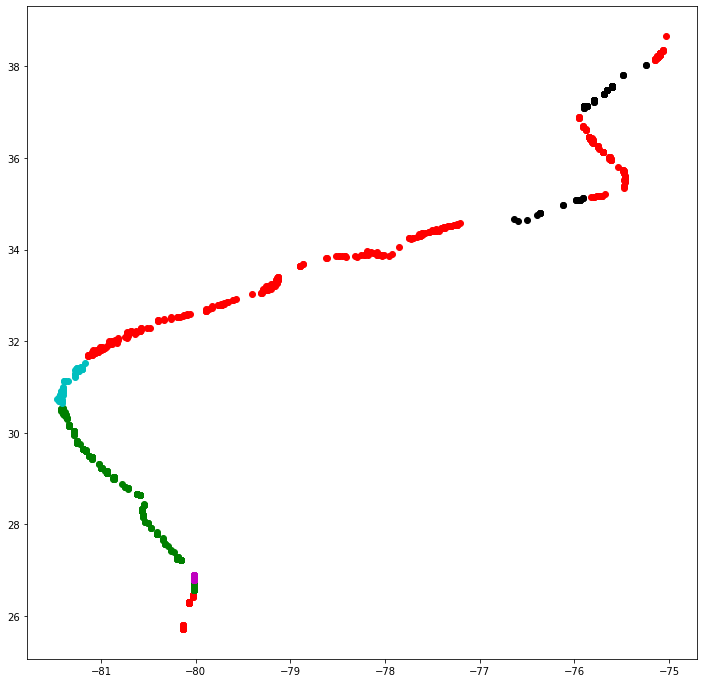

In [229]:
plt.figure(figsize=(12,12))

# plt.plot(tmp['longitude'], tmp['latitude'], '.',color=[.5,.5,.5])

plt.plot(df_strat_lat['longitude'][df_strat_lat['dataset']=='Fenster et al (2016)'], df_strat_lat['latitude'][df_strat_lat['dataset']=='Fenster et al (2016)'], 'ko')
plt.plot(df_strat_lat['longitude'][df_strat_lat['dataset']=='McFall, 2022'], df_strat_lat['latitude'][df_strat_lat['dataset']=='McFall, 2022'], 'ro')
# # plt.plot(df_strat_lat['longitude'][df_strat_lat['dataset']=='USGS East Coast Sediment Texture Database'], df_strat_lat['latitude'][df_strat_lat['dataset']=='USGS East Coast Sediment Texture Database'], 'ro')
plt.plot(df_strat_lat['longitude'][df_strat_lat['dataset']=='rossi'], df_strat_lat['latitude'][df_strat_lat['dataset']=='rossi'], 'go')
plt.plot(df_strat_lat['longitude'][df_strat_lat['dataset']=='C_Alexander'], df_strat_lat['latitude'][df_strat_lat['dataset']=='C_Alexander'], 'co')

# plt.plot(df_strat_lat['longitude'][df_strat_lat['dataset']=='Briggs (2022)'], df_strat_lat['latitude'][df_strat_lat['dataset']=='Briggs (2022)'], 'mo')

plt.plot(briggs['longitude'], briggs['latitude'], 'mo')


In [230]:
briggs = briggs[['hs_max', 'hs_mean', 'dir', 'tp', 'd50', 'beach_slope_average',
       'dataset', 'mstr', 'latitude', 'longitude']].copy()

In [231]:
briggs.keys()

Index(['hs_max', 'hs_mean', 'dir', 'tp', 'd50', 'beach_slope_average',
       'dataset', 'mstr', 'latitude', 'longitude'],
      dtype='object')

In [232]:
df_strat_lat = df_strat_lat[['hs_max', 'hs_mean', 'dir', 'tp', 'd50', 'beach_slope_average',
       'dataset', 'mstr', 'latitude', 'longitude']].copy()

In [233]:
df_strat_lat.keys()

Index(['hs_max', 'hs_mean', 'dir', 'tp', 'd50', 'beach_slope_average',
       'dataset', 'mstr', 'latitude', 'longitude'],
      dtype='object')

In [234]:
df = pd.concat([df_strat_lat, briggs], ignore_index=True)
df = df.dropna()
len(df)

1052

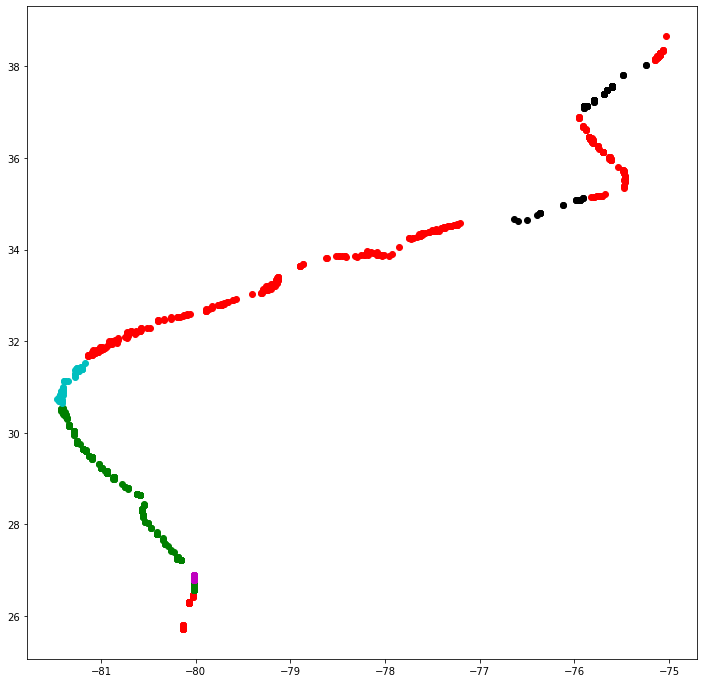

In [235]:
plt.figure(figsize=(12,12))

plt.plot(df['longitude'][df['dataset']=='Fenster et al (2016)'], df['latitude'][df['dataset']=='Fenster et al (2016)'], 'ko')
plt.plot(df['longitude'][df['dataset']=='McFall, 2022'], df['latitude'][df['dataset']=='McFall, 2022'], 'ro')

plt.plot(df['longitude'][df['dataset']=='rossi'], df['latitude'][df['dataset']=='rossi'], 'go')
plt.plot(df['longitude'][df['dataset']=='C_Alexander'], df['latitude'][df['dataset']=='C_Alexander'], 'co')

plt.plot(df['longitude'][df['dataset']=='Briggs (2022)'], df['latitude'][df['dataset']=='Briggs (2022)'], 'mo')

# plt.plot(briggs['longitude'], briggs['latitude'], 'mo')


In [236]:
(df['d50'].min(), df['d50'].max())

(0.090577125, 1.798733766)

(array([333., 233., 143., 140., 107.,  74.,   0.,  20.,   0.,   2.]),
 array([0.09057712, 0.26139279, 0.43220845, 0.60302412, 0.77383978,
        0.94465545, 1.11547111, 1.28628677, 1.45710244, 1.6279181 ,
        1.79873377]),
 <BarContainer object of 10 artists>)

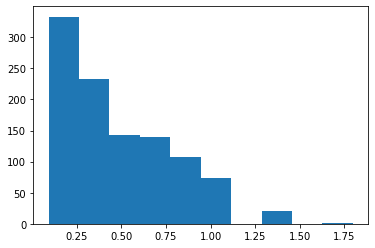

In [237]:
plt.hist(df['d50'])

In [238]:
df = df[df['d50']<1.5]

In [240]:
df_strat_gs = df.copy()

num_cats=8
num_samples_per_category = 50

df_strat_gs['category'] = pd.cut(df_strat_gs['d50'], num_cats)
df_strat_gs = df_strat_gs.groupby(['category']).apply(lambda x: x.sample(num_samples_per_category, replace = True)).reset_index(drop = True)

len(df_strat_gs)

400

In [241]:
np.unique(df_strat_gs['dataset'])

array(['Briggs (2022)', 'C_Alexander', 'Fenster et al (2016)',
       'McFall, 2022', 'rossi'], dtype=object)

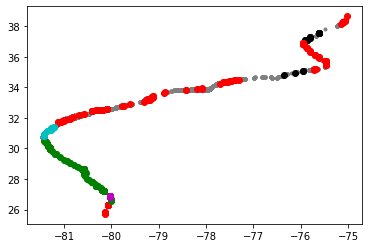

In [242]:
plt.plot(tmp['longitude'], tmp['latitude'], '.',color=[.5,.5,.5])

plt.plot(df_strat_gs['longitude'][df_strat_gs['dataset']=='Fenster et al (2016)'], df_strat_gs['latitude'][df_strat_gs['dataset']=='Fenster et al (2016)'], 'ko')
plt.plot(df_strat_gs['longitude'][df_strat_gs['dataset']=='McFall, 2022'], df_strat_gs['latitude'][df_strat_gs['dataset']=='McFall, 2022'], 'ro')
plt.plot(df_strat_gs['longitude'][df_strat_gs['dataset']=='rossi'], df_strat_gs['latitude'][df_strat_gs['dataset']=='rossi'], 'go')
plt.plot(df_strat_gs['longitude'][df_strat_gs['dataset']=='C_Alexander'], df_strat_gs['latitude'][df_strat_gs['dataset']=='C_Alexander'], 'co')

plt.plot(df_strat_gs['longitude'][df_strat_gs['dataset']=='Briggs (2022)'], df_strat_gs['latitude'][df_strat_gs['dataset']=='Briggs (2022)'], 'mo')



In [243]:
df_strat_gs['category']

0      (0.0893, 0.254]
1      (0.0893, 0.254]
2      (0.0893, 0.254]
3      (0.0893, 0.254]
4      (0.0893, 0.254]
            ...       
395     (1.235, 1.399]
396     (1.235, 1.399]
397     (1.235, 1.399]
398     (1.235, 1.399]
399     (1.235, 1.399]
Name: category, Length: 400, dtype: category
Categories (8, interval[float64, right]): [(0.0893, 0.254] < (0.254, 0.418] < (0.418, 0.581] < (0.581, 0.745] < (0.745, 0.908] < (0.908, 1.072] < (1.072, 1.235] < (1.235, 1.399]]

In [244]:
# df_strat_lon = tmp.copy()

# num_cats=6
# num_samples_per_category = 22

# df_strat_lon['category'] = pd.cut(df_strat_lon['d50'], num_cats)
# df_strat_lon = df_strat_lon.groupby(['category']).apply(lambda x: x.sample(num_samples_per_category, replace = True)).reset_index(drop = True)

# len(df_strat_lon)

In [245]:
# np.unique(df_strat_lon['dataset'])

In [246]:
# df = pd.concat([df_strat_gs, briggs], ignore_index=True)
# df = df.dropna()
# len(df)

In [247]:
df = df_strat_gs.copy()

Text(0.25, -78, '$R^2$=0.08')

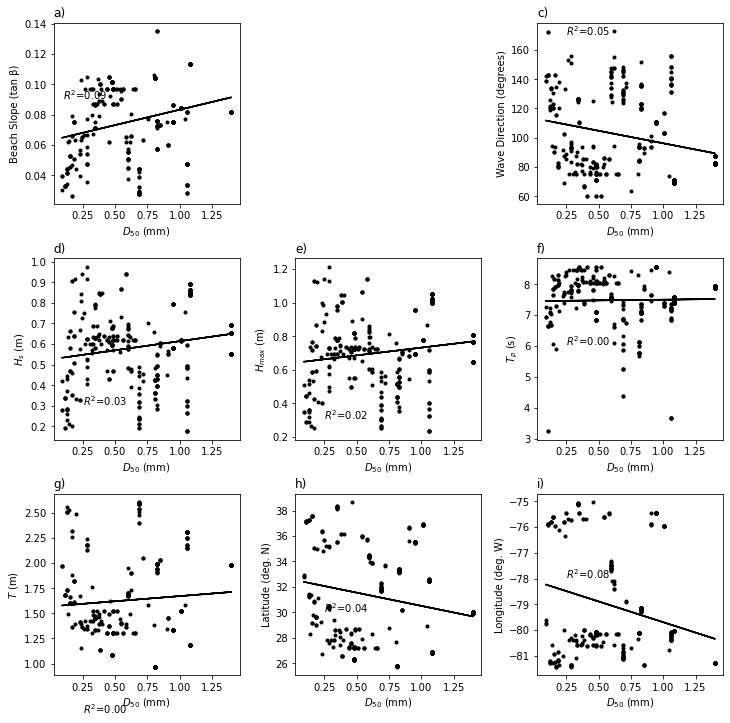

In [248]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(331)
plt.plot(df['d50'], df['beach_slope_average'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Beach Slope (tan β)')
plt.title("a)", loc='left')

coef = np.polyfit(df['d50'], df['beach_slope_average'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['beach_slope_average']))**2
plt.text(.1,.09,r'$R^2$='+str(r2)[:4])

# plt.subplot(332)
# plt.plot(df['d50'], df['trend'],'k.')
# plt.xlabel(r'$D_{50}$ (mm)')
# plt.ylabel('Shoreline trend (m/yr)')
# plt.title("b)", loc='left')

# coef = np.polyfit(df['d50'], df['trend'],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

# r2 = np.min(np.corrcoef(df['d50'], df['trend']))**2
# plt.text(.25,1.1,r'$R^2$='+str(r2)[:4])

plt.subplot(333)
plt.plot(df['d50'], df['dir'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Wave Direction (degrees)')
plt.title("c)", loc='left')

coef = np.polyfit(df['d50'], df['dir'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['dir']))**2
plt.text(.25,170,r'$R^2$='+str(r2)[:4])

plt.subplot(334)
plt.plot(df['d50'], df['hs_mean'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$H_{s}$ (m)')
plt.title("d)", loc='left')

coef = np.polyfit(df['d50'], df['hs_mean'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['hs_mean']))**2
plt.text(.25,.3,r'$R^2$='+str(r2)[:4])

plt.subplot(335)
plt.plot(df['d50'], df['hs_max'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$H_{max}$ (m)')
plt.title("e)", loc='left')

coef = np.polyfit(df['d50'], df['hs_max'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['hs_max']))**2
plt.text(.25,.3,r'$R^2$='+str(r2)[:4])

plt.subplot(336)
plt.plot(df['d50'], df['tp'],'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$T_{p}$ (s)')
plt.title("f)", loc='left')

coef = np.polyfit(df['d50'], df['tp'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['tp']))**2
plt.text(.25,6,r'$R^2$='+str(r2)[:4])

plt.subplot(337)
plt.plot(df['d50'],df['mstr'] ,'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$T$ (m)')
plt.title("g)", loc='left')

coef = np.polyfit(df['d50'], df['mstr'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['mstr']))**2
plt.text(.25,.5,r'$R^2$='+str(r2)[:4])

plt.subplot(338)
plt.plot(df['d50'],df['latitude'] ,'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'Latitude (deg. N)')
plt.title("h)", loc='left')

coef = np.polyfit(df['d50'], df['latitude'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['latitude']))**2
plt.text(.25,30,r'$R^2$='+str(r2)[:4])

plt.subplot(339)
plt.plot(df['d50'],df['longitude'] ,'k.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'Longitude (deg. W)')
plt.title("i)", loc='left')

coef = np.polyfit(df['d50'], df['longitude'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['longitude']))**2
plt.text(.25,-78,r'$R^2$='+str(r2)[:4])

# plt.savefig('data_plots/CGRASP_d50-linreg-df_strat_lat.jpg', dpi=300, bbox_inches='tight')

In [249]:
del df['category']
len(df)

400

In [92]:
# df.to_csv('../model_data/ML_slope_wave_atlantic_2022-05-18_Data_Post2012_VerifiedOnshore_0.0015_right_transects_model_stratsample-by-lat.csv')

In [93]:
# df.to_csv('../model_data/ML_slope_wave_atlantic_2022-08-31_Data_Post2012_VerifiedOnshore_0.0015_right_transects_model_stratsample-by-lat.csv')

In [94]:
# df.to_csv('../model_data/ML_slope_wave_atlantic_2022-9-4_Data_Post2012_VerifiedOnshore_0.0015_right_transects_model_stratsample-by-lat.csv')

In [600]:
# df.to_csv('../model_data/ML_slope_wave_atlantic_2022-9-7_Data_Post2012_VerifiedOnshore_0.0015_right_transects_model_stratsample-by-lat-by-gs.csv')

In [250]:
df.to_csv('../model_data/ML_slope_wave_atlantic_2022-9-20_Data_Post2012_VerifiedOnshore_0.0015_right_transects_model_stratsample-by-lat-by-gs.csv')